In [1]:
!pip install python-dotenv
!pip install snowflake-connector-python
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 962.5 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 2.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 3.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 245.7 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 2.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 157.7 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 130.7 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
load_dotenv()

print(f"PORT_POSTGRES: {os.getenv('PORT_POSTGRES')}")
print(f"POSTGRES_DB: {os.getenv('POSTGRES_DB')}")
print(f"POSTGRES_USER: {os.getenv('POSTGRES_USER')}")
print(f"POSTGRES_PASSWORD set: {bool(os.getenv('POSTGRES_PASSWORD'))}")

PORT_POSTGRES: 5432
POSTGRES_DB: ny_taxi
POSTGRES_USER: usuario_spark
POSTGRES_PASSWORD set: True


In [4]:
jar_path = "/home/jovyan/work/postgresql-42.2.5.jar"

spark = (
    SparkSession.builder
    .appName("ML_Desde_Postgres")
    .master("local[*]")
    .config("spark.jars", jar_path)
    .config("spark.driver.extraClassPath", jar_path)
    .config("spark.executor.extraClassPath", jar_path)
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "4g")
    .config("spark.driver.maxResultSize", "2g")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
    .getOrCreate()
)

In [5]:
sampled_query = """
(SELECT 
    passenger_count, trip_distance, pickup_hour, 
    pickup_dow, month, year, pu_location_id, service_type,
    vendor_id, rate_code_id, payment_type, total_amount
FROM analytics.obt_trips 
WHERE pickup_datetime IS NOT NULL
    AND total_amount BETWEEN 1 AND 1000
    AND trip_distance BETWEEN 0.1 AND 5000
    AND trip_duration_min BETWEEN 2 AND 500
    AND passenger_count BETWEEN 1 AND 7
    AND year BETWEEN 2022 AND 2024
) as sampled_trips
"""

df_sampled = (
    spark.read.format("jdbc")
    .option("url", f"jdbc:postgresql://warehouses:5432/{os.getenv('POSTGRES_DB')}")
    .option("driver", "org.postgresql.Driver")
    .option("dbtable", sampled_query)
    .option("user", os.getenv('POSTGRES_USER'))
    .option("password", os.getenv('POSTGRES_PASSWORD'))
    .option("fetchsize", "50000")
    .option("partitionColumn", "year")
    .option("lowerBound", 2022)
    .option("upperBound", 2024)
    .option("numPartitions", 3)
    .option("pushDownPredicate", "true")
    .load()
    .dropDuplicates()
)

print(f"Muestra cargada: {df_sampled.count():,} registros")

df_pd = df_sampled.toPandas()
print(f"Dataset en Pandas: {df_pd.shape}")

print("\nDistribución por año:")
print(df_pd['year'].value_counts().sort_index())

Muestra cargada: 1,078,728 registros
Dataset en Pandas: (1078575, 12)

Distribución por año:
year
2022    367526
2023    357277
2024    353772
Name: count, dtype: int64


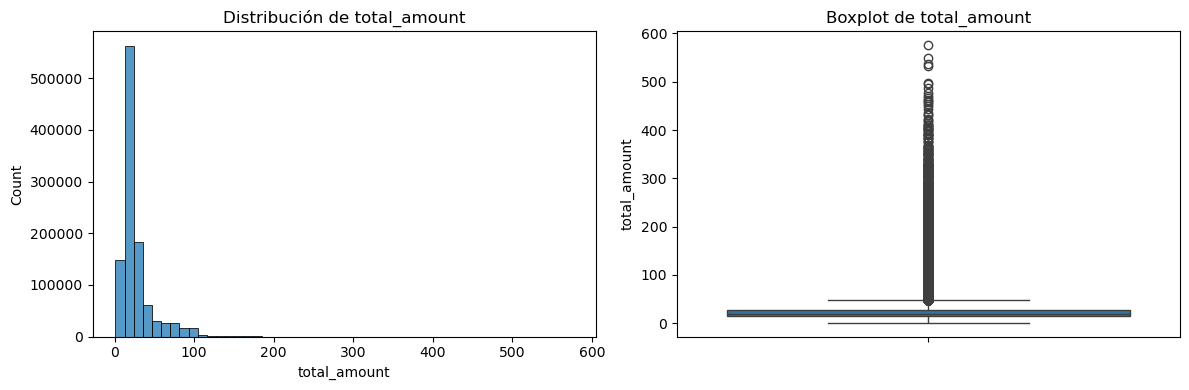

Estadísticas del target:
count     1078575
unique      12175
top         16.80
freq        13560
Name: total_amount, dtype: object


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df_pd['total_amount'], bins=50)
plt.title('Distribución de total_amount')
plt.subplot(1, 2, 2)
sns.boxplot(y=df_pd['total_amount'])
plt.title('Boxplot de total_amount')
plt.tight_layout()
plt.show()

print(f"Estadísticas del target:")
print(df_pd['total_amount'].describe())

In [7]:
numeric_features = [
    'passenger_count', 'trip_distance', 'pickup_hour', 
    'pickup_dow', 'month', 'year'
]

categorical_features = [
    'pu_location_id', 'service_type', 'vendor_id', 
    'rate_code_id', 'payment_type'
]

target = 'total_amount'

features = numeric_features + categorical_features
df_ml = df_pd[features + [target]].copy()

In [8]:
df_ml = df_ml.dropna()
print(f"Dataset después de limpieza: {df_ml.shape}")

df_ml['pu_location_id'] = df_ml['pu_location_id'].astype(int)
df_ml['pu_location_id'] = df_ml['pu_location_id'].apply(
    lambda x: x if x <= 265 else 266
)

Dataset después de limpieza: (1078575, 12)


In [9]:
train_data = df_ml[df_ml['year'] <= 2022].copy()
val_data = df_ml[df_ml['year'] == 2023].copy()
test_data = df_ml[df_ml['year'] == 2024].copy()

print(f"Train: {train_data.shape}")
print(f"Val: {val_data.shape}")
print(f"Test: {test_data.shape}")

Train: (367526, 12)
Val: (357277, 12)
Test: (353772, 12)


In [10]:
X_train = train_data[features]
y_train = train_data[target]

X_val = val_data[features]
y_val = val_data[target]

X_test = test_data[features]
y_test = test_data[target]

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', max_categories=50))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

baseline_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_val)

rmse_baseline = np.sqrt(mean_squared_error(y_val, y_pred_baseline))
mae_baseline = mean_absolute_error(y_val, y_pred_baseline)
r2_baseline = r2_score(y_val, y_pred_baseline)

print("Baseline (Regresion Lineal)")
print(f"RMSE: {rmse_baseline:.4f}")
print(f"MAE: {mae_baseline:.4f}")
print(f"R cuadrado: {r2_baseline:.4f}")

Baseline (Regresion Lineal)
RMSE: 11.2537
MAE: 7.6125
R cuadrado: 0.7505


In [13]:
from sklearn.ensemble import VotingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

tree_reg = DecisionTreeRegressor(
    max_depth=4,
    min_samples_split=150,
    min_samples_leaf=80,
    random_state=RANDOM_STATE
)

ridge_reg = Ridge(
    alpha=1.0,solver="sag",random_state=RANDOM_STATE
)

lasso_reg = Lasso(
    alpha=0.01,
    random_state=RANDOM_STATE,
    max_iter=50
)

voting_reg = VotingRegressor([
    ('tree', tree_reg),
    ('ridge', ridge_reg),
    ('lasso', lasso_reg)
], n_jobs=-1)

voting_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('voting', voting_reg)
])

voting_pipeline.fit(X_train, y_train)
y_pred_voting = voting_pipeline.predict(X_val)

In [14]:
bagging_reg = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=8, random_state=RANDOM_STATE),
    n_estimators=50,
    bootstrap=True,  # Bagging
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pasting_reg = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=8, random_state=RANDOM_STATE),
    n_estimators=50,
    bootstrap=False,  # Pasting
    random_state=RANDOM_STATE,
    n_jobs=-1
)

bagging_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('bagging', bagging_reg)
])

pasting_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pasting', pasting_reg)
])

bagging_pipeline.fit(X_train, y_train)
pasting_pipeline.fit(X_train, y_train)

y_pred_bagging = bagging_pipeline.predict(X_val)
y_pred_pasting = pasting_pipeline.predict(X_val)

In [15]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import time

# Configurar TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Pipeline para Gradient Boosting
gbr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('gbr', GradientBoostingRegressor(random_state=RANDOM_STATE))
])

# Parámetros para Grid Search
gbr_params = {
    'gbr__n_estimators': [50, 100],
    'gbr__learning_rate': [0.05, 0.1],
    'gbr__max_depth': [3, 4],
    'gbr__min_samples_split': [2],
    'gbr__subsample': [0.8]
}

# Grid Search con TimeSeriesSplit
print("Iniciando Grid Search para Gradient Boosting")
start_time = time.time()

gbr_grid = GridSearchCV(
    gbr_pipeline,
    gbr_params,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

gbr_grid.fit(X_train, y_train)
gbr_time = time.time() - start_time

print(f"Grid Search completado en {gbr_time:.2f} segundos")
print("Mejores parámetros Gradient Boosting:", gbr_grid.best_params_)

# Mejor modelo
best_gbr = gbr_grid.best_estimator_
y_pred_gbr = best_gbr.predict(X_val)

Iniciando Grid Search para Gradient Boosting
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Grid Search completado en 249.98 segundos
Mejores parámetros Gradient Boosting: {'gbr__learning_rate': 0.1, 'gbr__max_depth': 4, 'gbr__min_samples_split': 2, 'gbr__n_estimators': 100, 'gbr__subsample': 0.8}


In [16]:
from lightgbm import LGBMRegressor

# Pipeline para LightGBM
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lgbm', LGBMRegressor(random_state=RANDOM_STATE, verbose=-1))
])

# Parámetros para Grid Search
lgbm_params = {
    'lgbm__n_estimators': [50, 100],         
    'lgbm__learning_rate': [0.05, 0.1],            
    'lgbm__num_leaves': [31, 50],             
    'lgbm__max_depth': [-1],                
    'lgbm__min_child_samples': [20],          
    'lgbm__subsample': [0.8],              
    'lgbm__colsample_bytree': [0.8]        
}

print("Iniciando Grid Search para LightGBM")
start_time = time.time()

lgbm_grid = GridSearchCV(
    lgbm_pipeline,
    lgbm_params,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

lgbm_grid.fit(X_train, y_train)
lgbm_time = time.time() - start_time

print(f"Grid Search completado en {lgbm_time:.2f} segundos")
print("Mejores parámetros LightGBM:", lgbm_grid.best_params_)

# Mejor modelo
best_lgbm = lgbm_grid.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_val)

Iniciando Grid Search para LightGBM
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Grid Search completado en 53.92 segundos
Mejores parámetros LightGBM: {'lgbm__colsample_bytree': 0.8, 'lgbm__learning_rate': 0.1, 'lgbm__max_depth': -1, 'lgbm__min_child_samples': 20, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 50, 'lgbm__subsample': 0.8}


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(name, y_true, y_pred, fit_time=None):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    result = {
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R cuadrado': r2
    }
    
    if fit_time:
        result['Fit Time (s)'] = fit_time
    
    return result

# Evaluamos todos los modelos
results_val = []

results_val.append(evaluate_model('Baseline (Linear)', y_val, y_pred_baseline))
results_val.append(evaluate_model('Voting', y_val, y_pred_voting))
results_val.append(evaluate_model('Bagging', y_val, y_pred_bagging))
results_val.append(evaluate_model('Pasting', y_val, y_pred_pasting))
results_val.append(evaluate_model('Gradient Boosting', y_val, y_pred_gbr, gbr_time))
results_val.append(evaluate_model('LightGBM', y_val, y_pred_lgbm, lgbm_time))

results_df_val = pd.DataFrame(results_val)
print("\nResultados en Validacion (2023)")
print(results_df_val.round(4))


Resultados en Validacion (2023)
               Model     RMSE     MAE  R cuadrado  Fit Time (s)
0  Baseline (Linear)  11.2537  7.6125      0.7505           NaN
1             Voting  11.3249  7.5962      0.7474           NaN
2            Bagging  11.0111  7.5864      0.7612           NaN
3            Pasting  11.2176  7.6106      0.7521           NaN
4  Gradient Boosting  10.9078  7.5965      0.7656      249.9809
5           LightGBM  10.9124  7.5772      0.7654       53.9181


In [18]:
best_model_name = results_df_val.loc[results_df_val['RMSE'].idxmin(), 'Model']
print(f"Mejor modelo en validación: {best_model_name}")

if best_model_name == 'Gradient Boosting':
    best_model = best_gbr
elif best_model_name == 'LightGBM':
    best_model = best_lgbm
elif best_model_name == 'Voting':
    best_model = voting_pipeline
elif best_model_name == 'Bagging':
    best_model = bagging_pipeline
elif best_model_name == 'Pasting':
    best_model = pasting_pipeline
else:
    best_model = baseline_model

Mejor modelo en validación: Gradient Boosting


In [19]:
print(f"Evaluación final en Test 2024")
y_pred_test = best_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"RMSE Test: {rmse_test:.4f}")
print(f"MAE Test: {mae_test:.4f}")
print(f"R cuadrado Test: {r2_test:.4f}")

Evaluación final en Test 2024
RMSE Test: 11.5030
MAE Test: 7.9048
R cuadrado Test: 0.7476


## Conclusiones